In [115]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,cohen_kappa_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold,cross_val_score,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from pygam import LinearGAM, s, f
from datetime import datetime, timedelta
pd.set_option('display.max_columns', None)

In [116]:
records = pd.read_csv('combined_data_updated.csv')
records.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5302 entries, 0 to 5301
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 5302 non-null   int64  
 1   acute                 5302 non-null   float64
 2   acwr                  5302 non-null   float64
 3   chronic               5302 non-null   float64
 4   condition             5302 non-null   object 
 5   duration              5302 non-null   float64
 6   load                  5302 non-null   float64
 7   rpe                   5302 non-null   float64
 8   type                  5302 non-null   object 
 9   player_id             5302 non-null   object 
 10  name                  5293 non-null   object 
 11  formatteddate         5302 non-null   object 
 12  Activity              37 non-null     object 
 13  Classification        38 non-null     object 
 14  Location              36 non-null     object 
 15  OSIICs               

In [117]:
records = records.sort_values(by = ['formatteddate', 'player_id'])
records

,index,acute,acwr,chronic,condition,duration,load,rpe,type,player_id,name,formatteddate,Activity,Classification,Location,OSIICs,Onset,Past Injury,Reoccurance,Side,Surgery,FormattedInjuryDate,FormattedReturnDate,injury?,NeedActualInjuryDate,daydiff,actualInjuryDate,generalizedType,log_daydiff,age,height,weight
148,0,180.000000,1.000000,180.000000,Artificial (Dry),45.0,180.0,4.0,Practice (Field),5f014aa4b8bec1cf08f7ca0f,Zesh Rehman,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,36,190.0,83.400000
1255,8,325.000000,1.000000,325.000000,Artificial (Dry),65.0,325.0,5.0,Practice (Field),5f0592cc239906121f930928,TszTo Choy,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,21,177.0,73.200000
2613,7,390.000000,1.000000,390.000000,Artificial (Dry),65.0,390.0,6.0,Practice (Field),5f0592e2239906121f930929,Kota Kawase,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,28,189.0,82.600000
3380,6,325.000000,1.000000,325.000000,Artificial (Dry),65.0,325.0,5.0,Practice (Field),5f059326c37cc79a7d6a6ca9,james Ha,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,27,180.0,80.000000
3906,9,195.000000,1.000000,195.000000,Artificial (Dry),65.0,195.0,3.0,Practice (Field),5f059355c37cc79a7d6a6caa,Jack Sealy,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,33,173.0,75.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,5293,87.924115,0.514831,170.782587,Mixed,40.0,120.0,3.0,Quarantine - Run,60f254d8a1b3ec106cc401da,Khan Jahangir,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,22,174.0,67.100000
5301,5292,145.724642,0.652914,223.191242,Mixed,40.0,240.0,6.0,Quarantine - Run,60f254fb854df5b9da1bac56,LucianoDa Silva,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,35,185.0,87.300000
3098,5291,134.414729,0.724831,185.442837,Mixed,40.0,240.0,6.0,Quarantine - Run,6107d0a36f7b01ca9c0f6571,ChanKa Po,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,26,183.0,73.900000
2468,5303,91.835734,0.577736,158.958055,Mixed,40.0,200.0,5.0,Quarantine - Run,61139a2f859c5efc737749ba,Ju Yingzhi,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,False,NaN,NaN,Practice,NaN,35,175.0,84.574325


In [118]:
#records.to_csv('combined_data_updated.csv', header=True, index=False, encoding = 'utf-8')

In [119]:
def label_date(row):
    if row['injury?']==1:
        return row['actualInjuryDate']
    else:
        return row['formatteddate']

def posix_time(dt):
    return ((dt - datetime(2020, 6, 29)) / timedelta(seconds=1))/(24*60*60)

In [120]:
cols = ["formatteddate","FormattedInjuryDate","FormattedReturnDate","actualInjuryDate"]
for col in cols:
    records[col] = pd.to_datetime(records[col])

records['adjustedDate'] = records.apply(lambda x: label_date(x), axis=1)
records['adjustedDateDiff'] = records['adjustedDate'].apply(lambda x: posix_time(x))

In [121]:
records

,index,acute,acwr,chronic,condition,duration,load,rpe,type,player_id,name,formatteddate,Activity,Classification,Location,OSIICs,Onset,Past Injury,Reoccurance,Side,Surgery,FormattedInjuryDate,FormattedReturnDate,injury?,NeedActualInjuryDate,daydiff,actualInjuryDate,generalizedType,log_daydiff,age,height,weight,adjustedDate,adjustedDateDiff
148,0,180.000000,1.000000,180.000000,Artificial (Dry),45.0,180.0,4.0,Practice (Field),5f014aa4b8bec1cf08f7ca0f,Zesh Rehman,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,36,190.0,83.400000,2020-06-29,0.0
1255,8,325.000000,1.000000,325.000000,Artificial (Dry),65.0,325.0,5.0,Practice (Field),5f0592cc239906121f930928,TszTo Choy,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,21,177.0,73.200000,2020-06-29,0.0
2613,7,390.000000,1.000000,390.000000,Artificial (Dry),65.0,390.0,6.0,Practice (Field),5f0592e2239906121f930929,Kota Kawase,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,28,189.0,82.600000,2020-06-29,0.0
3380,6,325.000000,1.000000,325.000000,Artificial (Dry),65.0,325.0,5.0,Practice (Field),5f059326c37cc79a7d6a6ca9,james Ha,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,27,180.0,80.000000,2020-06-29,0.0
3906,9,195.000000,1.000000,195.000000,Artificial (Dry),65.0,195.0,3.0,Practice (Field),5f059355c37cc79a7d6a6caa,Jack Sealy,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,33,173.0,75.800000,2020-06-29,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,5293,87.924115,0.514831,170.782587,Mixed,40.0,120.0,3.0,Quarantine - Run,60f254d8a1b3ec106cc401da,Khan Jahangir,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,22,174.0,67.100000,2022-02-04,585.0
5301,5292,145.724642,0.652914,223.191242,Mixed,40.0,240.0,6.0,Quarantine - Run,60f254fb854df5b9da1bac56,LucianoDa Silva,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,35,185.0,87.300000,2022-02-04,585.0
3098,5291,134.414729,0.724831,185.442837,Mixed,40.0,240.0,6.0,Quarantine - Run,6107d0a36f7b01ca9c0f6571,ChanKa Po,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,26,183.0,73.900000,2022-02-04,585.0
2468,5303,91.835734,0.577736,158.958055,Mixed,40.0,200.0,5.0,Quarantine - Run,61139a2f859c5efc737749ba,Ju Yingzhi,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,35,175.0,84.574325,2022-02-04,585.0


In [122]:
set(records['condition'])#use onehot encoding

{'Artificial (Dry)',
 'Artificial (Wet)',
 'Grass (Dry)',
 'Grass (Wet)',
 'Gym/Indoors',
 'Hike',
 'Mixed',
 'None',
 'Sand',
 'Track'}

In [123]:
set(records['type'])#use ordinal encoding

{'Game',
 'Hike',
 'Modified',
 'None',
 'Practice (Beach)',
 'Practice (Field)',
 'Practice (Gym)',
 'Quarantine - Gym',
 'Quarantine - Run',
 'Rehab'}

In [124]:
# exclude the 'acute' onset
records = records[records['Onset'] != 'Acute']

In [125]:
records.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5278 entries, 148 to 3234
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   index                 5278 non-null   int64         
 1   acute                 5278 non-null   float64       
 2   acwr                  5278 non-null   float64       
 3   chronic               5278 non-null   float64       
 4   condition             5278 non-null   object        
 5   duration              5278 non-null   float64       
 6   load                  5278 non-null   float64       
 7   rpe                   5278 non-null   float64       
 8   type                  5278 non-null   object        
 9   player_id             5278 non-null   object        
 10  name                  5273 non-null   object        
 11  formatteddate         5278 non-null   datetime64[ns]
 12  Activity              14 non-null     object        
 13  Classification  

In [126]:
ohe = make_column_transformer(
    (OneHotEncoder(), ['condition', 'type']),
    remainder='passthrough')

ohe_transformed = ohe.fit_transform(records)
ohe_records = pd.DataFrame(
    ohe_transformed, 
    columns=ohe.get_feature_names()
)

/Users/hu/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [127]:
ohe_records

,onehotencoder__x0_Artificial (Dry),onehotencoder__x0_Artificial (Wet),onehotencoder__x0_Grass (Dry),onehotencoder__x0_Grass (Wet),onehotencoder__x0_Gym/Indoors,onehotencoder__x0_Hike,onehotencoder__x0_Mixed,onehotencoder__x0_None,onehotencoder__x0_Sand,onehotencoder__x0_Track,onehotencoder__x1_Game,onehotencoder__x1_Hike,onehotencoder__x1_Modified,onehotencoder__x1_None,onehotencoder__x1_Practice (Beach),onehotencoder__x1_Practice (Field),onehotencoder__x1_Practice (Gym),onehotencoder__x1_Quarantine - Gym,onehotencoder__x1_Quarantine - Run,onehotencoder__x1_Rehab,index,acute,acwr,chronic,duration,load,rpe,player_id,name,formatteddate,Activity,Classification,Location,OSIICs,Onset,Past Injury,Reoccurance,Side,Surgery,FormattedInjuryDate,FormattedReturnDate,injury?,NeedActualInjuryDate,daydiff,actualInjuryDate,generalizedType,log_daydiff,age,height,weight,adjustedDate,adjustedDateDiff
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,180.0,1.0,180.0,45.0,180.0,4.0,5f014aa4b8bec1cf08f7ca0f,Zesh Rehman,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,36,190.0,83.4,2020-06-29,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,325.0,1.0,325.0,65.0,325.0,5.0,5f0592cc239906121f930928,TszTo Choy,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,21,177.0,73.2,2020-06-29,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7,390.0,1.0,390.0,65.0,390.0,6.0,5f0592e2239906121f930929,Kota Kawase,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,28,189.0,82.6,2020-06-29,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6,325.0,1.0,325.0,65.0,325.0,5.0,5f059326c37cc79a7d6a6ca9,james Ha,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,27,180.0,80.0,2020-06-29,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9,195.0,1.0,195.0,65.0,195.0,3.0,5f059355c37cc79a7d6a6caa,Jack Sealy,2020-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,33,173.0,75.8,2020-06-29,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5293,87.924115,0.514831,170.782587,40.0,120.0,3.0,60f254d8a1b3ec106cc401da,Khan Jahangir,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,22,174.0,67.1,2022-02-04,585.0
5274,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5292,145.724642,0.652914,223.191242,40.0,240.0,6.0,60f254fb854df5b9da1bac56,LucianoDa Silva,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,35,185.0,87.3,2022-02-04,585.0
5275,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5291,134.414729,0.724831,185.442837,40.0,240.0,6.0,6107d0a36f7b01ca9c0f6571,ChanKa Po,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,26,183.0,73.9,2022-02-04,585.0
5276,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5303,91.835734,0.577736,158.958055,40.0,200.0,5.0,61139a2f859c5efc737749ba,Ju Yingzhi,2022-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0,False,NaN,NaT,Practice,NaN,35,175.0,84.574325,2022-02-04,585.0


In [144]:
ohe_records1 = ohe_records.drop(ohe_records.loc[:, 'Activity':'FormattedReturnDate'].columns,axis = 1)
#ohe_records1 = ohe_records.drop(ohe_records.loc[:, 'NeedActualInjuryDate'].columns,axis = 1)
ohe_records1 = ohe_records1.drop(ohe_records.loc[:, 'NeedActualInjuryDate':'generalizedType'].columns,axis = 1)

In [145]:
ohe_records1

,onehotencoder__x0_Artificial (Dry),onehotencoder__x0_Artificial (Wet),onehotencoder__x0_Grass (Dry),onehotencoder__x0_Grass (Wet),onehotencoder__x0_Gym/Indoors,onehotencoder__x0_Hike,onehotencoder__x0_Mixed,onehotencoder__x0_None,onehotencoder__x0_Sand,onehotencoder__x0_Track,onehotencoder__x1_Game,onehotencoder__x1_Hike,onehotencoder__x1_Modified,onehotencoder__x1_None,onehotencoder__x1_Practice (Beach),onehotencoder__x1_Practice (Field),onehotencoder__x1_Practice (Gym),onehotencoder__x1_Quarantine - Gym,onehotencoder__x1_Quarantine - Run,onehotencoder__x1_Rehab,index,acute,acwr,chronic,duration,load,rpe,player_id,name,formatteddate,injury?,log_daydiff,age,height,weight,adjustedDate,adjustedDateDiff
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,180.0,1.0,180.0,45.0,180.0,4.0,5f014aa4b8bec1cf08f7ca0f,Zesh Rehman,2020-06-29,0,NaN,36,190.0,83.4,2020-06-29,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,325.0,1.0,325.0,65.0,325.0,5.0,5f0592cc239906121f930928,TszTo Choy,2020-06-29,0,NaN,21,177.0,73.2,2020-06-29,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7,390.0,1.0,390.0,65.0,390.0,6.0,5f0592e2239906121f930929,Kota Kawase,2020-06-29,0,NaN,28,189.0,82.6,2020-06-29,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6,325.0,1.0,325.0,65.0,325.0,5.0,5f059326c37cc79a7d6a6ca9,james Ha,2020-06-29,0,NaN,27,180.0,80.0,2020-06-29,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,9,195.0,1.0,195.0,65.0,195.0,3.0,5f059355c37cc79a7d6a6caa,Jack Sealy,2020-06-29,0,NaN,33,173.0,75.8,2020-06-29,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5293,87.924115,0.514831,170.782587,40.0,120.0,3.0,60f254d8a1b3ec106cc401da,Khan Jahangir,2022-02-04,0,NaN,22,174.0,67.1,2022-02-04,585.0
5274,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5292,145.724642,0.652914,223.191242,40.0,240.0,6.0,60f254fb854df5b9da1bac56,LucianoDa Silva,2022-02-04,0,NaN,35,185.0,87.3,2022-02-04,585.0
5275,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5291,134.414729,0.724831,185.442837,40.0,240.0,6.0,6107d0a36f7b01ca9c0f6571,ChanKa Po,2022-02-04,0,NaN,26,183.0,73.9,2022-02-04,585.0
5276,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5303,91.835734,0.577736,158.958055,40.0,200.0,5.0,61139a2f859c5efc737749ba,Ju Yingzhi,2022-02-04,0,NaN,35,175.0,84.574325,2022-02-04,585.0


In [146]:
ohe_records1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 37 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   onehotencoder__x0_Artificial (Dry)  5278 non-null   object        
 1   onehotencoder__x0_Artificial (Wet)  5278 non-null   object        
 2   onehotencoder__x0_Grass (Dry)       5278 non-null   object        
 3   onehotencoder__x0_Grass (Wet)       5278 non-null   object        
 4   onehotencoder__x0_Gym/Indoors       5278 non-null   object        
 5   onehotencoder__x0_Hike              5278 non-null   object        
 6   onehotencoder__x0_Mixed             5278 non-null   object        
 7   onehotencoder__x0_None              5278 non-null   object        
 8   onehotencoder__x0_Sand              5278 non-null   object        
 9   onehotencoder__x0_Track             5278 non-null   object        
 10  onehotencoder__x1_Game  

In [147]:
ohe_records1 = ohe_records1.drop(['log_daydiff', 'index'], axis = 1)
ohe_records1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   onehotencoder__x0_Artificial (Dry)  5278 non-null   object        
 1   onehotencoder__x0_Artificial (Wet)  5278 non-null   object        
 2   onehotencoder__x0_Grass (Dry)       5278 non-null   object        
 3   onehotencoder__x0_Grass (Wet)       5278 non-null   object        
 4   onehotencoder__x0_Gym/Indoors       5278 non-null   object        
 5   onehotencoder__x0_Hike              5278 non-null   object        
 6   onehotencoder__x0_Mixed             5278 non-null   object        
 7   onehotencoder__x0_None              5278 non-null   object        
 8   onehotencoder__x0_Sand              5278 non-null   object        
 9   onehotencoder__x0_Track             5278 non-null   object        
 10  onehotencoder__x1_Game  

In [148]:
for i in range(len(ohe_records1.columns)):
    if i != 26 and i != 27 and i != 28 and i != 33:
        ohe_records1.iloc[:,i]= ohe_records1.iloc[:,i].astype(str)
        ohe_records1.iloc[:,i] = ohe_records1.iloc[:,i].apply(lambda x: float(x))
        

In [149]:
ohe_records1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5278 entries, 0 to 5277
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   onehotencoder__x0_Artificial (Dry)  5278 non-null   float64       
 1   onehotencoder__x0_Artificial (Wet)  5278 non-null   float64       
 2   onehotencoder__x0_Grass (Dry)       5278 non-null   float64       
 3   onehotencoder__x0_Grass (Wet)       5278 non-null   float64       
 4   onehotencoder__x0_Gym/Indoors       5278 non-null   float64       
 5   onehotencoder__x0_Hike              5278 non-null   float64       
 6   onehotencoder__x0_Mixed             5278 non-null   float64       
 7   onehotencoder__x0_None              5278 non-null   float64       
 8   onehotencoder__x0_Sand              5278 non-null   float64       
 9   onehotencoder__x0_Track             5278 non-null   float64       
 10  onehotencoder__x1_Game  

In [150]:
ohe_records1

,onehotencoder__x0_Artificial (Dry),onehotencoder__x0_Artificial (Wet),onehotencoder__x0_Grass (Dry),onehotencoder__x0_Grass (Wet),onehotencoder__x0_Gym/Indoors,onehotencoder__x0_Hike,onehotencoder__x0_Mixed,onehotencoder__x0_None,onehotencoder__x0_Sand,onehotencoder__x0_Track,onehotencoder__x1_Game,onehotencoder__x1_Hike,onehotencoder__x1_Modified,onehotencoder__x1_None,onehotencoder__x1_Practice (Beach),onehotencoder__x1_Practice (Field),onehotencoder__x1_Practice (Gym),onehotencoder__x1_Quarantine - Gym,onehotencoder__x1_Quarantine - Run,onehotencoder__x1_Rehab,acute,acwr,chronic,duration,load,rpe,player_id,name,formatteddate,injury?,age,height,weight,adjustedDate,adjustedDateDiff
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,180.000000,1.000000,180.000000,45.0,180.0,4.0,5f014aa4b8bec1cf08f7ca0f,Zesh Rehman,2020-06-29,0.0,36.0,190.0,83.400000,2020-06-29,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,325.000000,1.000000,325.000000,65.0,325.0,5.0,5f0592cc239906121f930928,TszTo Choy,2020-06-29,0.0,21.0,177.0,73.200000,2020-06-29,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,390.000000,1.000000,390.000000,65.0,390.0,6.0,5f0592e2239906121f930929,Kota Kawase,2020-06-29,0.0,28.0,189.0,82.600000,2020-06-29,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,325.000000,1.000000,325.000000,65.0,325.0,5.0,5f059326c37cc79a7d6a6ca9,james Ha,2020-06-29,0.0,27.0,180.0,80.000000,2020-06-29,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,195.000000,1.000000,195.000000,65.0,195.0,3.0,5f059355c37cc79a7d6a6caa,Jack Sealy,2020-06-29,0.0,33.0,173.0,75.800000,2020-06-29,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5273,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,87.924115,0.514831,170.782587,40.0,120.0,3.0,60f254d8a1b3ec106cc401da,Khan Jahangir,2022-02-04,0.0,22.0,174.0,67.100000,2022-02-04,585.0
5274,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,145.724642,0.652914,223.191242,40.0,240.0,6.0,60f254fb854df5b9da1bac56,LucianoDa Silva,2022-02-04,0.0,35.0,185.0,87.300000,2022-02-04,585.0
5275,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,134.414729,0.724831,185.442837,40.0,240.0,6.0,6107d0a36f7b01ca9c0f6571,ChanKa Po,2022-02-04,0.0,26.0,183.0,73.900000,2022-02-04,585.0
5276,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,91.835734,0.577736,158.958055,40.0,200.0,5.0,61139a2f859c5efc737749ba,Ju Yingzhi,2022-02-04,0.0,35.0,175.0,84.574325,2022-02-04,585.0


In [153]:
ohe_records1.to_csv('combined_data_after_ohe.csv', index = False)

# split the train and validation dataset

In [151]:
# all features except for name,player_id, and two dt columns
X = ohe_records1.drop(columns = ['player_id','name','formatteddate','adjustedDate','injury?'], axis = 1)
y = ohe_records1['injury?']

#X_train,X_validation,y_train,y_validation = train_test_split(X,y,test_size=0.5,random_state=42,stratify = y)
split_idx = 2880
X_train = X.iloc[:split_idx,:]
X_validation = X.iloc[split_idx:,:]
y_train = y.iloc[:split_idx]
y_validation = y.iloc[split_idx:]

In [152]:
print(sum(y_validation.tolist()))
print(len(y_validation.tolist()))
print(sum(y_validation.tolist()+y_train.tolist()))
print(len(y_validation.tolist()+y_train.tolist()))

4.0
2398
14.0
5278


978/5278

In [39]:
758/5278

0.1436150056839712

14.0/5278

In [40]:
14.0/5278

0.002652519893899204

# models

As unbalanced data (a lot of 0's and few 1's), precision and recall are very important. There is a parameter called scale_pos_weight, which will help tell the model the distribution of your data. I have found this to greatly improve the performance of "rare event" cases. 

In [137]:
rf_model = RandomForestClassifier(random_state=42)
gbm_model = GradientBoostingClassifier(random_state=42)
xgb_model = XGBClassifier(scale_pos_weight=1/0.00265,random_state=42)

##define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
#for train_index, test_index in cv.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    
##evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
##summarize performance
print('Mean ROC AUC: %.5f' % np.mean(scores))

In [138]:
def eval_metrics(model, X_train, y_train, X_validation, y_validation):
    model.fit(X_train, y_train)

    preds = model.predict(X_validation)
    prob = model.predict_proba(X_validation)
    probs = prob[:, 1]

    acc = (preds == y_validation).sum().astype(float) / len(preds)*100
    kappa = cohen_kappa_score(y_validation, preds)

    numerator_pre = 0 
    denominator_pre = 0
    for i in range(len(preds)):
        if preds[i]==1:
            denominator_pre += 1
            if y_validation.tolist()[i] == 1:
                numerator_pre += 1
                
    if denominator_pre == 0:
        precision = None
    else:
        precision = numerator_pre/denominator_pre


    numerator_rec = 0 
    denominator_rec = 0
    for i in range(len(preds)):
        if y_validation.tolist()[i]==1:
            denominator_rec += 1
            if preds[i] == 1:
                numerator_rec += 1
                
    if denominator_rec == 0:
        recall = None
    else:
        recall = numerator_rec/denominator_rec
    return kappa, precision, recall, acc, preds, probs


def ts_validation(model,X_train,y_train,train_idx_lst):
    kappa_lst = list()
    precision_lst = list()
    recall_lst = list()
    
    for train_idx in train_idx_lst:
        X_train_i = X_train.iloc[:train_idx,:]
        #print(len(X_train_i))
        y_train_i = y_train.iloc[:train_idx]
        #print(len(y_train_i))
        X_test_i = X_train.iloc[(train_idx+1):,:]
        #print(len(X_test_i))
        y_test_i = y_train.iloc[(train_idx+1):]
        #print(len(y_test_i))
        kappa, precision, recall, acc, y_pred, probs = eval_metrics(model, X_train_i, y_train_i, X_test_i, y_test_i)
        kappa_lst.append(kappa)
        precision_lst.append(precision)
        recall_lst.append(recall)
        
    kappa_avg = np.mean(kappa_lst)
    #print(precision_lst)
    precision_avg = np.mean(precision_lst)
    recall_avg = np.mean(recall_lst)
    return kappa_avg, precision_avg, recall_avg

In [139]:
def plot_roc(model,X_validation,y_validation):
    y_pred_prob = model.predict_proba(X_validation)

    # roc curve for models and auc
    fpr, tpr, _ = roc_curve(y_validation, y_pred_prob[:,1], pos_label=1)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    # roc curve for tpr = fpr 
    random_probs = [0 for i in range(len(y_validation))]
    p_fpr, p_tpr, _ = roc_curve(y_validation, random_probs, pos_label=1)



    # -------- plot the roc curve ----------
    plt.style.use('seaborn')

    # plot roc curves
    plt.plot(fpr, tpr, linestyle='--',color='orange', label='Xgboost')
    plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive Rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show()


In [154]:
# something you need to set carefully
train_idx_lst = [1300,1800,2200, 2850]
#train_idx_lst = [3400, 3800,4200,4300]

## xgb

In [155]:
kappa_cv, precision_cv, recall_cv = ts_validation(xgb_model,X_train,y_train,train_idx_lst)

print("XGB Classifier's kappa score of the time series cross validation: {0:0.4f}". format(kappa_cv))
print("XGB Classifier's precision of the time series cross validation: {0:0.4f}". format(precision_cv))
print("XGB Classifier's recall rate of the time series cross validation: {0:0.4f}". format(recall_cv))

XGB Classifier's kappa score of the time series cross validation: 0.5753
XGB Classifier's precision of the time series cross validation: 0.8500
XGB Classifier's recall rate of the time series cross validation: 0.4688


In [156]:
kappa_xgb, precision_xgb, recall_xgb, acc_xgb, y_pred_xgb, y_prob_xgb = eval_metrics(xgb_model, X_train, y_train, X_validation, y_validation)
print("XGB Classifier's prediction accuracy: %3.2f" % (acc_xgb))
print("XGB Classifier's kappa score: {0:0.4f}". format(kappa_xgb))
print("XGB Classifier's precision: {0:0.4f}".format(precision_xgb))
print("XGB Classifier's recall: {0:0.4f}".format(recall_xgb))

XGB Classifier's prediction accuracy: 99.71
XGB Classifier's kappa score: -0.0014
XGB Classifier's precision: 0.0000
XGB Classifier's recall: 0.0000


In [157]:
y_pred_xgb_list = y_pred_xgb.tolist()
indices_xgb = [i for i, x in enumerate(y_pred_xgb_list) if x == 1]
indices_xgb

[41, 2213, 2342]

In [158]:
y_prob_xgb_list = y_prob_xgb.tolist()
[y_prob_xgb_list[i] for i in indices_xgb]

[0.5430148839950562, 0.6275759339332581, 0.5335429310798645]

In [159]:
player_id_lst = ohe_records1['player_id'].iloc[split_idx:].tolist()
adjusted_date = ohe_records1['formatteddate'].iloc[split_idx:].tolist()
true_label = ohe_records['injury?'].iloc[split_idx:].tolist()
output = pd.DataFrame({'player_id':player_id_lst, 'y_prob_xgb':y_prob_xgb_list, 
                       'y_prob_label':y_pred_xgb_list, 'date':adjusted_date,
                      'injury_label':true_label})

output.to_csv('output_xgb.csv')
output.loc[output['injury_label']==1]

,player_id,y_prob_xgb,y_prob_label,date,injury_label
78,6107d0a36f7b01ca9c0f6571,0.000659,0,2021-08-12,1
353,5f059326c37cc79a7d6a6ca9,0.000245,0,2021-09-07,1
519,5f059388239906121f93092f,0.012579,0,2021-09-21,1
646,611a41e057d5db652811c0f3,0.084656,0,2021-09-30,1


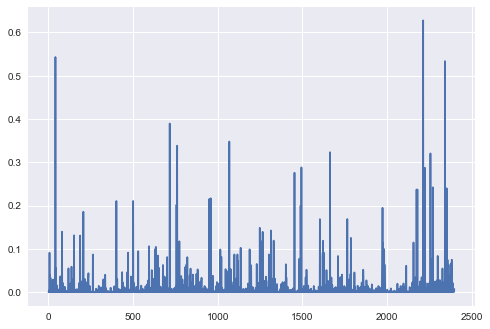

In [162]:
plt.plot(y_prob_xgb_list)

0.6750730994152047


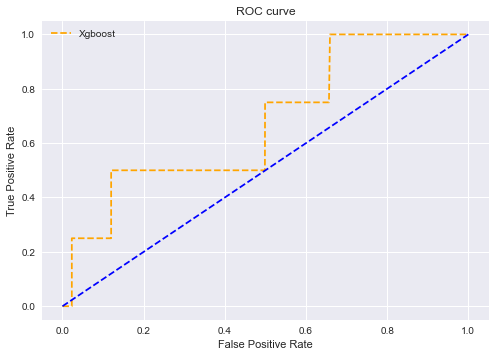

In [161]:
plot_roc(xgb_model, X_validation,y_validation)

## rf 

In [163]:
kappa_cv, precision_cv, recall_cv = ts_validation(rf_model,X_train,y_train,train_idx_lst)
print("RF Classifier's kappa score of the time series cross validation: {0:0.4f}". format(kappa_cv))
print("RF Classifier's precision of the time series cross validation: {0:0.4f}". format(precision_cv))
print("RF Classifier's recall rate of the time series cross validation: {0:0.4f}". format(recall_cv))

RF Classifier's kappa score of the time series cross validation: 0.6314
RF Classifier's precision of the time series cross validation: 1.0000
RF Classifier's recall rate of the time series cross validation: 0.4688


In [164]:
kappa_rf, precision_rf, recall_rf, acc_rf, y_pred_rf, y_prob_rf = eval_metrics(rf_model, X_train, y_train, X_validation, y_validation)
print("RF Classifier's prediction accuracy: %3.2f" % (acc_rf))
print("RF Classifier's kappa score: {0:0.4f}". format(kappa_rf))
#print("RF Classifier's precision: {0:0.4f}".format(precision_rf))
print("RF Classifier's recall: {0:0.4f}".format(recall_rf))

RF Classifier's prediction accuracy: 99.83
RF Classifier's kappa score: 0.0000
RF Classifier's recall: 0.0000


In [165]:
y_pred_rf_list = y_pred_rf.tolist()
indices_rf = [i for i, x in enumerate(y_pred_rf_list) if x == 1]
indices_rf

[]

In [166]:
y_prob_rf_list = y_prob_rf.tolist()
[y_prob_rf_list[i] for i in indices_rf]

[]

In [167]:
output = pd.DataFrame({'player_id':player_id_lst, 'y_prob_rf':y_prob_rf_list, 
                       'y_prob_label':y_pred_rf_list, 'date':adjusted_date,
                      'injury_label':true_label})

output.to_csv('output_rf.csv')
output.loc[output['injury_label']==1]

,player_id,y_prob_rf,y_prob_label,date,injury_label
78,6107d0a36f7b01ca9c0f6571,0.01,0.0,2021-08-12,1
353,5f059326c37cc79a7d6a6ca9,0.03,0.0,2021-09-07,1
519,5f059388239906121f93092f,0.11,0.0,2021-09-21,1
646,611a41e057d5db652811c0f3,0.14,0.0,2021-09-30,1


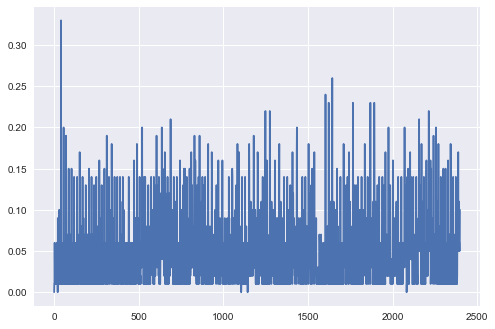

In [168]:
plt.plot(y_prob_rf_list)

0.6333542188805346


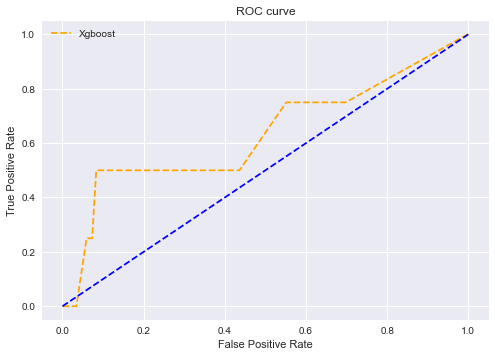

In [169]:
plot_roc(rf_model, X_validation,y_validation)

## gbm

In [170]:
kappa_cv, precision_cv, recall_cv = ts_validation(gbm_model,X_train,y_train,train_idx_lst)
print("GBM Classifier's kappa score of the time series cross validation: {0:0.4f}". format(kappa_cv))
print("GBM Classifier's precision of the time series cross validation: {0:0.4f}". format(precision_cv))
print("GBM Classifier's recall rate of the time series cross validation: {0:0.4f}". format(recall_cv))

GBM Classifier's kappa score of the time series cross validation: 0.5222
GBM Classifier's precision of the time series cross validation: 0.6792
GBM Classifier's recall rate of the time series cross validation: 0.4688


In [171]:
kappa_gbm, precision_gbm, recall_gbm, acc_gbm, y_pred_gbm, y_prob_gbm = eval_metrics(gbm_model, X_train, y_train, X_validation, y_validation)
print("RF Classifier's prediction accuracy: %3.2f" % (acc_gbm))
print("RF Classifier's kappa score: {0:0.4f}". format(kappa_gbm))
print("RF Classifier's precision: {0:0.4f}".format(precision_gbm))
print("RF Classifier's recall: {0:0.4f}".format(recall_gbm))

RF Classifier's prediction accuracy: 94.08
RF Classifier's kappa score: -0.0033
RF Classifier's precision: 0.0000
RF Classifier's recall: 0.0000


In [172]:
y_pred_gbm_list = y_pred_gbm.tolist()
indices_gbm = [i for i, x in enumerate(y_pred_gbm_list) if x == 1]
indices_gbm

[41,
 56,
 70,
 86,
 103,
 118,
 136,
 151,
 168,
 187,
 206,
 221,
 236,
 249,
 267,
 281,
 297,
 311,
 324,
 340,
 357,
 373,
 389,
 406,
 441,
 472,
 489,
 505,
 520,
 538,
 556,
 573,
 589,
 605,
 619,
 636,
 654,
 670,
 688,
 707,
 725,
 744,
 762,
 783,
 784,
 810,
 829,
 845,
 859,
 876,
 892,
 910,
 931,
 932,
 959,
 970,
 993,
 994,
 995,
 1032,
 1052,
 1053,
 1076,
 1092,
 1110,
 1128,
 1152,
 1153,
 1179,
 1202,
 1203,
 1232,
 1250,
 1274,
 1275,
 1304,
 1329,
 1330,
 1358,
 1377,
 1395,
 1408,
 1433,
 1434,
 1466,
 1484,
 1503,
 1519,
 1537,
 1603,
 1622,
 1642,
 1643,
 1671,
 1691,
 1710,
 1725,
 1742,
 1765,
 1766,
 1795,
 1816,
 1835,
 1852,
 1868,
 1891,
 1892,
 1920,
 1939,
 1957,
 1975,
 2001,
 2002,
 2032,
 2051,
 2070,
 2086,
 2103,
 2121,
 2139,
 2155,
 2156,
 2170,
 2184,
 2199,
 2213,
 2227,
 2241,
 2256,
 2270,
 2284,
 2299,
 2312,
 2327,
 2342,
 2357,
 2373,
 2387]

In [173]:
y_prob_gbm_list = y_prob_gbm.tolist()
[y_prob_gbm_list[i] for i in indices_gbm]

[0.9999992183929626,
 0.9999987458234887,
 0.9999987458234887,
 0.9999987458234887,
 0.9999987458234887,
 0.9999987458234887,
 0.9999987458234887,
 0.9999987458234887,
 0.9999987458234887,
 0.9999986909542887,
 0.9999986909542887,
 0.9999985594857602,
 0.9999985594857602,
 0.9999985337527861,
 0.9999985594853836,
 0.9999985594853836,
 0.9999985594853836,
 0.9999985594853836,
 0.9999985594853836,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985594853836,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337531694,
 0.9999985337527861,
 0.9999985337531694,
 0.9999985337527861,
 0.9999985594853836,
 0.9999985337527861,
 0.9999985594853836,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985337531694,
 0.9999985594857602,
 0.9999985405653807,
 0.9999985337527861,
 0.9999985337527861,
 0.9999985594

In [174]:
output = pd.DataFrame({'player_id':player_id_lst, 'y_prob_rf':y_prob_gbm_list, 
                       'y_prob_label':y_pred_gbm_list, 'date':adjusted_date,
                      'injury_label':true_label})

output.to_csv('output_gbm.csv')
#output.loc[output['injury_label']==1]
output.loc[(output['y_prob_label']==1)&(output['injury_label']==0)]

,player_id,y_prob_rf,y_prob_label,date,injury_label
41,5f0593d9c37cc79a7d6a6cae,0.999999,1.0,2021-08-10,0
56,5f0593d9c37cc79a7d6a6cae,0.999999,1.0,2021-08-11,0
70,5f0593d9c37cc79a7d6a6cae,0.999999,1.0,2021-08-12,0
86,5f0593d9c37cc79a7d6a6cae,0.999999,1.0,2021-08-13,0
103,5f0593d9c37cc79a7d6a6cae,0.999999,1.0,2021-08-16,0
...,...,...,...,...,...
2327,5f0593d9c37cc79a7d6a6cae,0.999999,1.0,2022-01-26,0
2342,5f0593d9c37cc79a7d6a6cae,0.999999,1.0,2022-01-27,0
2357,5f0593d9c37cc79a7d6a6cae,0.999999,1.0,2022-01-28,0
2373,5f0593d9c37cc79a7d6a6cae,0.999999,1.0,2022-01-31,0


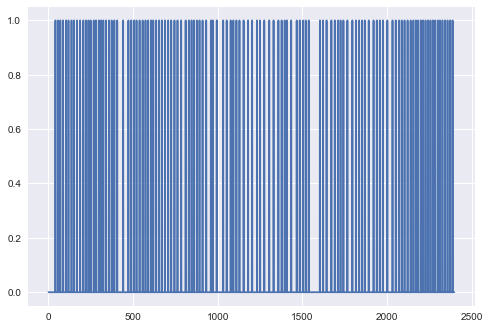

In [175]:
plt.plot(y_prob_gbm_list)

0.28393901420217205


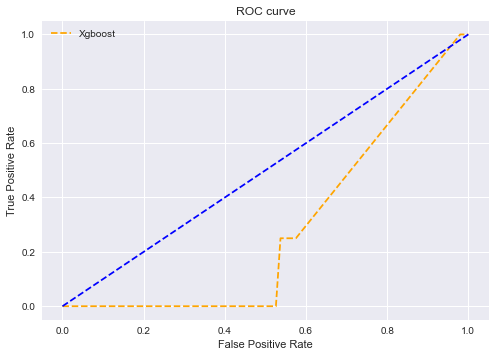

In [176]:
plot_roc(gbm_model, X_validation,y_validation)

In [116]:
for i in range(len(y_validation.tolist())):
    if y_validation.tolist()[i]==1:
        print(i)

print()
print(len(y_validation.tolist()))

216
237
421
562
595

978


In [117]:
for i in range(len(y_pred_xgb.tolist())):
    if y_pred_xgb.tolist()[i]==1:
        print(i)

print()
print(len(y_pred_xgb.tolist()))

18
96
216
257
272

978


In [118]:
for i in range(len(y_pred_rf.tolist())):
    if y_pred_rf.tolist()[i]==1:
        print(i)

print()
print(len(y_pred_rf.tolist()))

216

978


In [119]:
for i in range(len(y_pred_gbm.tolist())):
    if y_pred_gbm.tolist()[i]==1:
        print(i)

print()
print(len(y_pred_gbm.tolist()))

216
229
257
272
667
724

978


In [177]:
def plot_feature_imp(model):
    sorted_idx = model.feature_importances_.argsort()
    plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
    plt.title('Feature importance')

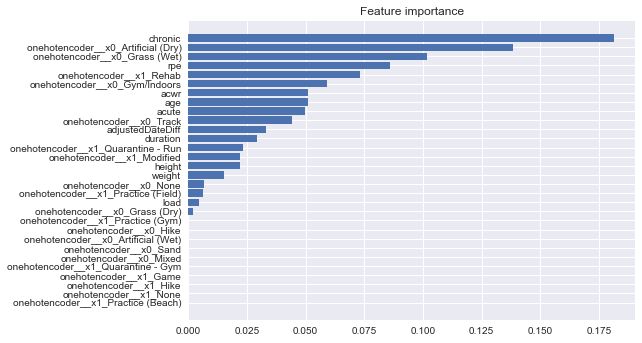

In [178]:
plot_feature_imp(xgb_model)

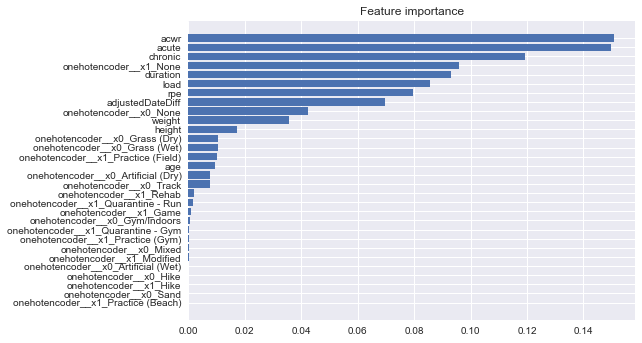

In [179]:
plot_feature_imp(rf_model)

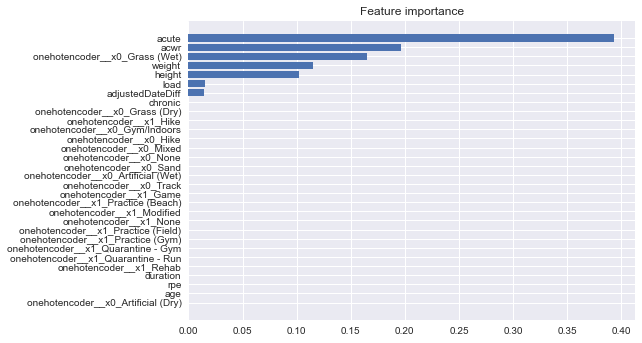

In [180]:
plot_feature_imp(gbm_model)

In [43]:
# Time series split wrt train and validation, acute onset included 
#XGB Classifier's prediction accuracy: 98.38
#XGB Classifier's kappa score: 0.3035
#XGB Classifier's precision: 1.0000
#XGB Classifier's recall: 0.1818


# time series split wrt train and validation, acute onset exclueded
#XGB Classifier's prediction accuracy: 99.45
#XGB Classifier's kappa score: 0.5692
#XGB Classifier's precision: 1.0000
#XGB Classifier's recall: 0.4000


# stratified split wrt train and validation, acute onset included
# a kappa score of 0.3302, 
# precision of 0.5000, 
# recall rate of 0.2500, 
# and an accuracy of 99.31%

In [44]:
# simple queries,
# loop through

# present the result of probability with labels of 1 or 0
# traffic light on front end